# Práctica 4 Visión por Computador
## Autores:
- Héctor Wood Santana
- Alejandro Viera Ruiz 

## Tarea:

Para la entrega de esta práctica, la tarea consiste en desarrollar un prototipo que procese uno (vídeo ejemplo proporcionado) o varios vídeos (incluyendo vídeos de cosecha propia):
- detecte y siga las personas y vehículos presentes
- detecte y lea las matrículas de los vehículos presentes
- cuente el total de cada clase
- vuelque a disco un vídeo que visualice los resultados
- genere un archivo csv con el resultado de la detección y seguimiento. Se sugiere un formato con al menos los siguientes campos:

        fotograma, tipo_objeto, confianza, identificador_tracking, x1, y1, x2, y2, matrícula_en_su_caso, confianza, mx1,my1,mx2,my2, texto_matricula

La entrega del cuaderno o cuadernos se hace efectiva a través del campus virtual por medio de un enlace github. Además del archivo README, debe incluirse el resultado del vídeo proporcionado como test (o enlace al mismo), y el correspondiente archivo csv. En el caso de entrenarse algún detector, por ejemplo de matrículas, debe proporcionarse acceso al conjunto de datos.

Se considerarán extras:
- Determine el flujo de personas y vehículos en el vídeo de test en distintas direcciones (vehículos que dejan la imagen por la derecha, por la izquierda, etc.)
- Participar en
- Evaluar dos alternativas para la detección de matrículas: basada en YOLO, y basada en contornos.
- Anonimizar a las personas y vehículos presentes en un vídeo.

In [1]:
import cv2  
import math 
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import re

from ultralytics import YOLO
from collections import defaultdict

In [ ]:
# Modelo de yolo que se usará para la detección de vehículos y personas.
model = YOLO('yolo11n.pt')

A continuación se añade seguimiento a la detección del modelo base. (*Tracking*)

In [ ]:
# Video de prueba
filename = "TUD-Crossing.webm"

# Seguimiento, con persistencia entre fotogramas
results = model.track(filename, persist=True, show=True, classes=[0,1,2,3])
cv2.destroyAllWindows()

Hasta ahora, es posible reconocer los distintos vehículos así como las personas que aparecen en el video. Sin embargo, el modelo no está entrenado para reconocer las placas de matrículas (*license plates*). Por lo tanto, a continuación, se procede a reentrenar el modelo para detectar las matrículas como una nueva clase, cuya etiqueta asignada será *"license-plate"*.

Para más información del archivo .yaml, leer el README.md de la práctica 4.

In [ ]:
#Entrenamiento de modelo con dataset propio
model.train(data="custom_dataset.yml", epochs=20, imgsz=416, device=0)

New https://pypi.org/project/ultralytics/8.3.24 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.21  Python-3.12.7 torch-2.5.0 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=custom_dataset.yml, epochs=20, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning D:\DESCARGAS\carrera\2024-25\Primer semestre\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\labels... 2718 images, 60 backgrounds, 0 corrupt: 100%|██████████| 2718/2718 [00:06<00:00, 397.72it/s]

train: WARNING  D:\DESCARGAS\carrera\2024-25\Primer semestre\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\images\JR-9568_png.rf.72c6c419a82a4ae7826e8e13ceb0b659.jpg: 1 duplicate labels removed
train: WARNING  D:\DESCARGAS\carrera\2024-25\Primer semestre\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\images\JR-9568_png.rf.8e448f6780c3a3575ab3efe9336f621d.jpg: 1 duplicate labels removed
train: WARNING  D:\DESCARGAS\carrera\2024-25\Primer semestre\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\images\JR-9568_png.rf.a79073a624fa19d50c6d813eaf3aaaa0.jpg: 1 duplicate labels removed
train: WARNING  D:\DESCARGAS\carrera\2024-25\Primer semestre\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\images\LC-1812_png.rf.07d8f14bfe8f38a37c4b76682d22f112.jpg: 1 duplicate labels removed
train: WARNING  D:\DESCARGAS\carrera\2024-25\Primer semestre\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\images\LC-1812_png.rf.cf2225fa787499903df2f3de67253e6c.jpg: 1 duplicate 

train: New cache created: D:\DESCARGAS\carrera\2024-25\Primer semestre\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\labels.cache


val: Scanning D:\DESCARGAS\carrera\2024-25\Primer semestre\VC\VC\Practica_4\datasets\registrringsnummerv12i\valid\labels... 256 images, 5 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:01<00:00, 173.91it/s]


val: New cache created: D:\DESCARGAS\carrera\2024-25\Primer semestre\VC\VC\Practica_4\datasets\registrringsnummerv12i\valid\labels.cache
Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.23G     0.8476      1.219     0.9933         38        416: 100%|██████████| 170/170 [00:50<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.39it/s]

                   all        256        264      0.925      0.932      0.959      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.27G     0.8448      0.725     0.9772         35        416: 100%|██████████| 170/170 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

                   all        256        264      0.917      0.928       0.94      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.28G     0.8129     0.6284     0.9688         38        416: 100%|██████████| 170/170 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]

                   all        256        264      0.919      0.958      0.968      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.28G     0.7881     0.5686     0.9557         33        416: 100%|██████████| 170/170 [00:47<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]

                   all        256        264      0.932      0.943      0.962      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.28G     0.7688     0.5477     0.9546         31        416: 100%|██████████| 170/170 [00:48<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        256        264      0.934      0.955      0.974      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.28G     0.7054     0.5045     0.9408         38        416: 100%|██████████| 170/170 [00:49<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.39it/s]

                   all        256        264       0.94      0.977      0.967      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.28G      0.684     0.4876     0.9322         40        416: 100%|██████████| 170/170 [00:50<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        256        264      0.954      0.935       0.97      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.28G     0.6582     0.4566     0.9282         35        416: 100%|██████████| 170/170 [00:50<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        256        264      0.941      0.975      0.986      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.28G     0.6497     0.4495     0.9233         39        416: 100%|██████████| 170/170 [00:50<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        256        264      0.947       0.97      0.977       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.28G     0.6304     0.4363     0.9214         36        416: 100%|██████████| 170/170 [00:50<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        256        264      0.948       0.96      0.974      0.824


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.28G     0.5887     0.4287     0.8861         15        416: 100%|██████████| 170/170 [00:46<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.43it/s]

                   all        256        264      0.927      0.955      0.972      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.28G     0.5792     0.4117     0.8836         14        416: 100%|██████████| 170/170 [00:49<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

                   all        256        264      0.958      0.949      0.973      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.28G     0.5557     0.3841     0.8759         14        416: 100%|██████████| 170/170 [00:49<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]

                   all        256        264      0.949      0.985      0.978      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.28G     0.5351     0.3707      0.875         13        416: 100%|██████████| 170/170 [00:50<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

                   all        256        264      0.955      0.985      0.975      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.28G     0.5023     0.3463     0.8685         14        416: 100%|██████████| 170/170 [00:50<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

                   all        256        264       0.97       0.98      0.978      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.28G     0.4841     0.3335     0.8646         14        416: 100%|██████████| 170/170 [00:50<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        256        264      0.959      0.992      0.979      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.28G     0.4574     0.3169     0.8588         14        416: 100%|██████████| 170/170 [00:49<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

                   all        256        264      0.963      0.989      0.979      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.28G     0.4462     0.3095     0.8519         14        416: 100%|██████████| 170/170 [00:49<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

                   all        256        264      0.974      0.992      0.978      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.28G     0.4262     0.2918     0.8517         12        416: 100%|██████████| 170/170 [00:50<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.38it/s]

                   all        256        264      0.968      0.989      0.979       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.28G     0.3991     0.2766     0.8455         14        416: 100%|██████████| 170/170 [00:47<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

                   all        256        264      0.969      0.989      0.982      0.902



20 epochs completed in 0.307 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.4MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.21  Python-3.12.7 torch-2.5.0 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.47it/s]


                   all        256        264      0.969      0.989       0.98      0.901
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000025D2B46EBD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

Se muestra la matriz de confusión resultante:

(np.float64(-0.5), np.float64(2999.5), np.float64(2249.5), np.float64(-0.5))

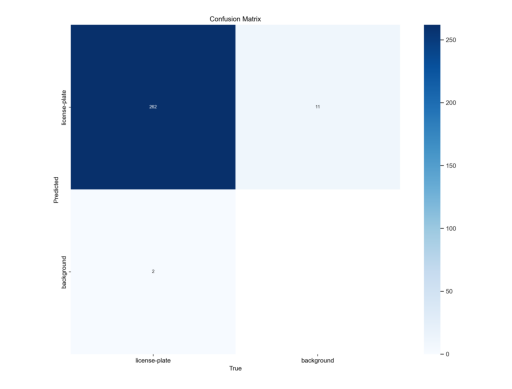

In [5]:
# Carga del modelo con mejor resultado tras el entrenamiento:
cm = cv2.imread("./runs/detect/train/confusion_matrix.png")
cm = cv2.cvtColor(cm, cv2.COLOR_BGR2RGB)

plt.imshow(cm)
plt.axis('off')


Finalmente, para lograr el objetivo de la práctica, se usa el modelo base 'yolo11n.pt' en conjunto con el modelo entrenado con mejores resultados 'best.pt', para detectar los coches dentro de un video y extraer sus matrículas.

In [6]:
#Cargar los modelos a utilizar para la detección de clases
det_vehicles = YOLO("yolo11n.pt")
det_plates = YOLO("runs/detect/train/weights/best.pt")


#Ruta al ejecutable de Tesseract OCR
pytesseract.pytesseract.tesseract_cmd = r'D:/Programs/Tesseract-OCR/tesseract.exe' # "C:/Program Files/Tesseract-OCR/tesseract" o "D:/Programs/Tesseract-OCR/tesseract.exe"

# Etiqueta de las distintas clases
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus"]


vid = 'C0142.MP4'
cap = cv2.VideoCapture(vid)

track_history = defaultdict(lambda: [])

while(True):      
    #Fotograma a fotograma
    ret, img = cap.read()
  
    #Si hay imagen válida
    if ret:  
        #Seguimiento, con persistencia entre fotogramas
        results = det_vehicles.track(img, persist=True, classes = [0, 2, 3, 5])

        if 0:
            if results is not None:
                boxes = results[0].boxes.xywh.cpu()
                track_ids = results[0].boxes.id.int().cpu().tolist()
                annotated_frame = results[0].plot()
                for box, track_id in zip(boxes, track_ids):
                    x, y, w, h = box
                    track = track_history[track_id]
                    track.append((float(x), float(y)))
                    if len(track) > 30:
                        track.pop(0)
                    points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                    cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)
                cv2.imshow("YOLO11 Tracking", annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
        

        
        #Para cada detección
        for r in results:
            boxes = r.boxes

            for box in boxes:
                #Contenedor
                x1, y1, x2, y2 = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
                if (box.cls == 2) and (box.conf[0] > 0.7):
                    vehicle_crop = img[y1:y2, x1:x2]  # Recorte del área del vehículo

                    #Detección de matrículas en el recorte del vehículo
                    plate_results = det_plates(vehicle_crop)

                    #Procesar detecciones de matrículas
                    for plate in plate_results[0].boxes:
                        px1, py1, px2, py2 = map(int, plate.xyxy[0])

                        #Ajustar coordenadas al espacio de la imagen original
                        abs_x1, abs_y1 = x1 + px1, y1 + py1
                        abs_x2, abs_y2 = x1 + px2, y1 + py2

                        #Recorte de la matrícula y reconocimiento de texto con Tesseract
                        plate_crop = vehicle_crop[py1:py2, px1:px2]
                        plate_text = pytesseract.image_to_string(plate_crop, config='--psm 8')  # OCR

                        plate_text = re.sub('[^A-Za-z0-9]', '', plate_text)

                        #Visualización de bounding box de la matrícula de coche
                        cv2.rectangle(img, (abs_x1, abs_y1), (abs_x2, abs_y2), (0, 255, 0), 1)
                        
                        #Visualización del texto de la matrícula (tesseract)
                        #cv2.putText(img, f'Plate: {plate_text}', (abs_x1, abs_y1 - 10),
                        #            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                        #print(f"Matrícula detectada: {plate_text}")  # Imprimir matrícula en consola

                #Etiqueta de seguimiento
                if box.id is not None:
                    track_id = str(int(box.id[0].tolist()))
                else:
                    track_id = ''
                
                # Confianza
                confidence = math.ceil((box.conf[0]*100))/100
                print("Confianza --->",confidence)

                # Clase
                cls = int(box.cls[0])
                print("Clase -->", classNames[cls])

                # Dibuja el contenedor y clase
                cv2.rectangle(img, (x1, y1), (x2, y2), (127, 127, 127), 3)
                cv2.putText(img, track_id + ' ' + classNames[cls] + ' ' + str(confidence), [x1, y1], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 127), 2)

        # Muestra fotograma
        cv2.imshow('Vid', img)
    
    # Detenemos pulsado ESC
    if cv2.waitKey(20) == 27:
        break
  
# Libera el objeto de captura
cap.release()
# Destruye ventanas
cv2.destroyAllWindows()




0: 384x640 1 car, 1 bus, 116.5ms
Speed: 5.0ms preprocess, 116.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Confianza ---> 0.94
Clase --> bus

0: 320x416 (no detections), 20.7ms
Speed: 1.5ms preprocess, 20.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 416)
Confianza ---> 0.85
Clase --> car

0: 384x640 1 car, 1 bus, 22.9ms
Speed: 4.0ms preprocess, 22.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Confianza ---> 0.94
Clase --> bus

0: 352x416 (no detections), 22.6ms
Speed: 1.0ms preprocess, 22.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 416)
Confianza ---> 0.82
Clase --> car

0: 384x640 1 car, 1 bus, 19.1ms
Speed: 3.0ms preprocess, 19.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Confianza ---> 0.94
Clase --> bus

0: 352x416 (no detections), 37.7ms
Speed: 1.0ms preprocess, 37.7ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 416)
Confianza ---> 0.82
Clase --> car

0: 3